# Bayesian Inference

This notebook is about bayesian inference. Bayesian inference is a probabilistic approach to data analysis greatly appreciated thanks to its ability to quantify the uncertainty in the data. Moreover, it allows to include sources of information other than the data (eg, the opinion of an expert). 

This notebook nicely combines with other notebooks form this repository which covered A/B testing.


This notebook is inspired by the tutorial from https://github.com/rasmusab/bayesianprobabilitiesworkshop/blob/master/Exercise%201.ipynb

---

### Ingredients

Bayesian data analysis needs:
- data: in this case the number of customers signing up after seeing the proposed add.
- a generative model: in this case the only parameter that the model needs is the sign up probability, which can be modeled as a binomial distribution.
- prior information: to infer the parameter from the data, we need to consider a range of possible parameter values. In this case, the only prior information we have is that the probability of signup can range between 0 and 1, so a natural choice is to represent prior information with a uniform distribution

### Recipe

A typical bayesian inference approach now consists in:
1. run a large number of simulations where a possible parameter value is drawn from the prior and used to simulate the process that generated the original dataset
2. answer the question "Which parameter value gave me simulated data that were very similar to the original data?"


We will use three scenarios to walk through the steps of a data science project relying on bayesian inference.

**Scenario A**: our ecommerce shop sends an ad to its clients. Based on the few data collected, what can we say about the convergence rate of the add?

**Scenario B**: our ecommerce shop sends an ad to some clients clients, and another one to other clients. Based on the few data collected, which add seems to do better? 




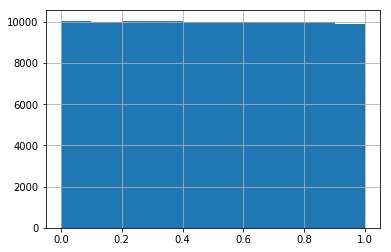

In [5]:
### SCENARIO A

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of random draws from the prior
n_draws = 100000

# Ingredient 1: we use a uniform prior and sample n_draws draws from a uniform prior 
prior = pd.Series(np.random.uniform(0, 1, size = n_draws ))
prior.hist()
plt.show()

In [2]:
# Ingredient 2: Let's now define the generative model
def generative_model(parameters):
    signups = np.random.binomial(parameters[0], parameters[1]) # returns number of successes
    return(signups)

# for instance, let's simulate 3 times sending the ad to 20 people, with a signup rate of 0.1
for i in np.arange(3):
    print(generative_model([20, 0.1]))

3
4
3


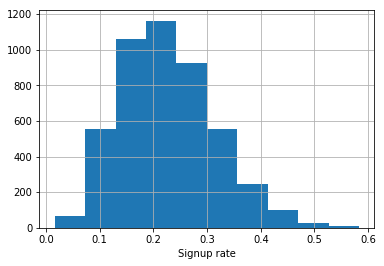

In [3]:
# Ingredient 3: the actual data
N_participants = 20
N_signups = 4

# Now we are ready to simulate the testing campaing as much as we want!
sim_data = list()
for p in prior:
    sim_data.append(generative_model([ N_participants, p]))
                    
# Next, we keep only the draws (and associated parameter) that match the observed data
posterior = pd.Series(
    [prior[idx] for idx in range(len(sim_data)) if sim_data[idx] == N_signups])

# eyeball the posterior
ax = posterior.hist()
ax.set_xlabel('Signup rate')
plt.show()

In [4]:
# it is common sense to check that we got enought draws left after the filtering. 
# it appears a safe number here could be something like >1000.
print('Number of draws used to create the posterior: %.0f' % len(posterior))

# Some summary statistics
print('Posterior median: %.3f, Posterior quantile interval: %.3f-%.3f' % 
      (posterior.median(), posterior.quantile(.025), posterior.quantile(.975)))


Number of draws used to create the posterior: 4709
Posterior median: 0.218, Posterior quantile interval: 0.081-0.420


### Comparing to a baseline
Imagine now, that we want to know if this ad has a signup rate higher than 15%.
This can be done very simply by integrating over the posterior from 0.15 to 1:

In [17]:
p_signup_rate_higer_than_15pc = len(posterior[posterior > 0.15]) / len(posterior)
print('Based on the collected date, we estiamte a %.2f%%  probability that the ad has a conversion rate higher than 15%%.'  % (100 * p_signup_rate_higer_than_15pc))

Based on the collected date, we estiamte a 79.70%  probability that the ad has a conversion rate higher than 15%.


### Making predictions
Imagine now, that we would like to estimate how the ad would perform if it were presented to 100 people. 
Again, the answer will come in the form of a probability distribution.


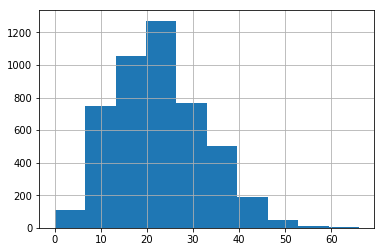

Sign-up 95% quantile interval 7-44


In [52]:
predicted_signups = pd.Series([generative_model([100, p]) for p in posterior])
predicted_signups.hist()
plt.show()

print('Sign-up 95%% quantile interval %d-%d' % tuple(predicted_signups.quantile([.025, .975]).values))

### Incorporating available knowledge
Now let's imagine that an "expert" told us that convergence rate is usually between 5 and 20%.

This information could be very valuable, and bring some extra money to the business. How can we incorporate it in the model?

One natural way would be to change the prior, from the uninformative uniform distribution to a distribution that better fits the opinion of the expert.



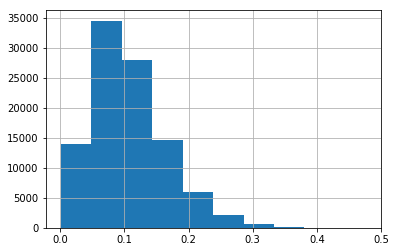

In [59]:
# prior
prior = pd.Series(np.random.beta(3, 25, size = n_draws ))
prior.hist()
plt.show()
# In general, the more data we have the less the prior is affecting the output. 
# But beware of making too lose statements, as they can really affect the outcome when datasets are of smaller sizes (as uit is tipically the case)


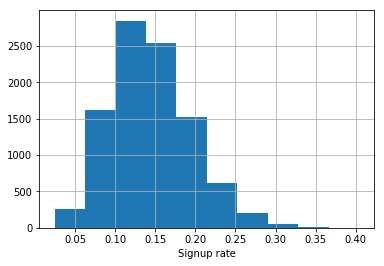

In [57]:
# the rest of the analysis is simply a copy-paste from the previous one

sim_data = list()
for p in prior:
    sim_data.append(generative_model([ N_participants, p]))
                    
#keep only the draws matching the observed data
posterior = pd.Series(
    [prior[idx] for idx in range(len(sim_data)) if sim_data[idx] == N_signups])

# eyeball the posterior
ax = posterior.hist()
ax.set_xlabel('Signup rate')
plt.show()


In [ ]:
# SCENARIO B